In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval,pairs_from_exhaustive

## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [5]:
images = Path('/src/matcher_engine/HierarchicalLocalization/datasets/isl2-20221101/db')
outputs = Path('outputs/isl2-20221101/')

sfm_pairs = outputs / 'pairs-netvlad.txt'
sfm_dir = outputs / 'sfm_superpoint+superglue'
#feature_path = outputs / 'feats-superpoint-n4096-r1024.h5'
#retrieval_path = outputs / 'openibl_4096.h5'
#match_path = outputs / "feats-superpoint-n4096-r1024_matches-superglue_pairs-custom_retrieved.h5"

retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [ ]:
if not images.exists():
    !wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [6]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2023/01/19 04:06:15.088Z hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2023/01/19 04:06:15.091Z hloc INFO] Found 48 images in root /src/matcher_engine/HierarchicalLocalization/datasets/isl2-20221101/db.
[2023/01/19 04:06:15.093Z hloc INFO] Start delete query feature: outputs/isl2-20221101/global-feats-netvlad.h5
[2023/01/19 04:06:15.094Z hloc INFO] Start skip pairs: outputs/isl2-20221101/global-feats-netvlad.h5
[2023/01/19 04:06:22.182Z hloc INFO] Finished setup model for feature extraction
100%|██████████| 48/48 [00:04<00:00, 11.70it/s]
[2023/01/19 04:06:26.292Z hloc INFO] Finished exporting features.
[2023/01/19 04:06:26.293Z hloc INFO] Extracting image pairs from a retrieval database.
[2023/01/19 04:06:26.366Z hloc INFO] Found 240 pairs.


## Extract and match local features

In [7]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[2023/01/19 04:06:36.237Z hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2023/01/19 04:06:36.241Z hloc INFO] Found 48 images in root /src/matcher_engine/HierarchicalLocalization/datasets/isl2-20221101/db.
[2023/01/19 04:06:36.241Z hloc INFO] Start delete query feature: outputs/isl2-20221101/feats-superpoint-n4096-r1024.h5
[2023/01/19 04:06:36.242Z hloc INFO] Start skip pairs: outputs/isl2-20221101/feats-superpoint-n4096-r1024.h5


Loaded SuperPoint model


[2023/01/19 04:06:36.276Z hloc INFO] Finished setup model for feature extraction
100%|██████████| 48/48 [00:01<00:00, 27.80it/s]
[2023/01/19 04:06:38.006Z hloc INFO] Finished exporting features.
[2023/01/19 04:06:38.011Z hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


[2023/01/19 04:06:38.216Z hloc INFO] Start delete query matching: outputs/isl2-20221101/feats-superpoint-n4096-r1024_matches-superglue_pairs-netvlad.h5
[2023/01/19 04:06:38.217Z hloc INFO] Start skip pairs: outputs/isl2-20221101/feats-superpoint-n4096-r1024_matches-superglue_pairs-netvlad.h5
[2023/01/19 04:06:38.217Z hloc INFO] Finished setup model for matching
 61%|██████    | 146/240 [00:36<00:23,  4.00it/s][2023/01/19 04:07:14.484Z hloc INFO] Matching pair: p001-d6-f00022.jpg_p001-d0-f00013.jpg
[2023/01/19 04:07:14.583Z hloc INFO] Matching pair: p001-d6-f00022.jpg_p001-d5-f00091.jpg
 87%|████████▋ | 208/240 [00:50<00:06,  4.74it/s][2023/01/19 04:07:28.778Z hloc INFO] Matching pair: p001-d0-f00013.jpg_p001-d6-f00022.jpg
[2023/01/19 04:07:28.876Z hloc INFO] Matching pair: p001-d0-f00013.jpg_p001-d7-f00094.jpg
100%|██████████| 240/240 [00:58<00:00,  4.12it/s]
[2023/01/19 04:07:36.407Z hloc INFO] Finished exporting matches.


In [8]:
feature_path

PosixPath('outputs/isl2-20221101/feats-superpoint-n4096-r1024.h5')

## 3D reconstruction
Run COLMAP on the features and matches.

In [9]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2023/01/19 04:07:52.378Z hloc INFO] Creating an empty database...
[2023/01/19 04:07:53.192Z hloc INFO] Importing images into the database...
[2023/01/19 04:07:53.693Z hloc INFO] Importing features into the database...
100%|██████████| 48/48 [00:00<00:00, 2175.56it/s]
[2023/01/19 04:07:53.934Z hloc INFO] Importing matches into the database...
100%|██████████| 240/240 [00:00<00:00, 4676.68it/s]
[2023/01/19 04:07:54.130Z hloc INFO] Performing geometric verification of the matches...
[2023/01/19 04:07:54.604Z hloc INFO] Running 3D reconstruction...
[2023/01/19 04:09:04.630Z hloc INFO] Reconstructed 1 model(s).
[2023/01/19 04:09:04.632Z hloc INFO] Largest model is #0 with 48 images.
[2023/01/19 04:09:04.634Z hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 48
	num_cameras = 48
	num_points3D = 10509
	num_observations = 41056
	mean_track_length = 3.90675
	mean_observations_per_image = 855.333
	mean_reprojection_error = 1.20379
	num_input_images = 48


In [10]:
model

<Reconstruction 'num_reg_images=48, num_cameras=48, num_points3D=10509, num_observations=41056'>

## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=5)

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='track_length', n=5)

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='depth', n=5)

In [ ]:
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

## Localizelol

In [3]:
import pycolmap as pc
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

model = pc.Reconstruction()
model.read(str(sfm_dir))
print(model.summary())

Reconstruction:
	num_reg_images = 104
	num_cameras = 1
	num_points3D = 32725
	num_observations = 117932
	mean_track_length = 3.60373
	mean_observations_per_image = 1133.96
	mean_reprojection_error = 1.24264


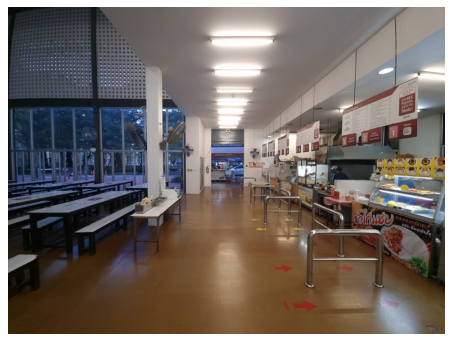

In [4]:
from pathlib import Path
query_path = Path("/src/matcher_engine/HierarchicalLocalization/datasets/canteen-20221115/images")
im_path = 'db/p002-d0-f00049.jpg'
full_im_path = query_path / im_path
plot_images([read_image(full_im_path)], dpi=75)

In [5]:
feature_conf

{'output': 'feats-superpoint-n4096-r1024',
 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096},
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}

In [6]:
images = Path('/src/matcher_engine/HierarchicalLocalization/datasets/canteen-20221115/images')

In [7]:
extract_features.main(feature_conf, images, image_list=[im_path], feature_path=feature_path, overwrite=True)

[2023/01/17 13:32:10.752Z hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2023/01/17 13:32:10.755Z hloc INFO] Start delete query feature: outputs/canteen-20221115/feats-superpoint-n4096-r1024.h5
[2023/01/17 13:32:10.758Z hloc INFO] Start skip pairs: outputs/canteen-20221115/feats-superpoint-n4096-r1024.h5


Loaded SuperPoint model


[2023/01/17 13:32:12.869Z hloc INFO] Finished setup model for feature extraction
100%|██████████| 1/1 [00:00<00:00, 18.61it/s]
[2023/01/17 13:32:12.929Z hloc INFO] Finished exporting features.


PosixPath('outputs/canteen-20221115/feats-superpoint-n4096-r1024.h5')

In [8]:
loc_pairs = outputs / 'pairs-loc.txt'

In [9]:
loc_pairs

PosixPath('outputs/canteen-20221115/pairs-loc.txt')

In [179]:
references = [i[1].name for i in model.images.items()]
# pairs_from_exhaustive.main(loc_pairs, image_list=[im_path], ref_list=references)
pairs_from_retrieval.main(retrieval_path, loc_pairs, 10, query_list=[im_path], db_prefix="db")

references = [i.split(" ")[1] for i in open(loc_pairs, 'r').read().split("\n")]
references

[2023/01/17 14:29:05.334Z hloc INFO] Extracting image pairs from a retrieval database.
[2023/01/17 14:29:05.441Z hloc INFO] Found 10 pairs.


['db/p001-d0-f00025.jpg',
 'db/p000-d0-f00001.jpg',
 'db/p003-d0-f00073.jpg',
 'db/p007-d0-f00169.jpg',
 'db/p003-d4-f00085.jpg',
 'db/p002-d1-f00052.jpg',
 'db/p001-d1-f00028.jpg',
 'db/p004-d4-f00109.jpg',
 'db/p002-d7-f00070.jpg',
 'db/p002-d4-f00061.jpg']

In [180]:
loc_pairs

PosixPath('outputs/canteen-20221115/pairs-loc.txt')

In [181]:
def remove_image_from_pairs(db_im_names, inverse=False):
    fd = open(loc_pairs, 'r')
    txt = list(fd.read().split("\n"))
    fd.close()
    new_txt = []
    query_name = txt[0].split(" ")[0]
    for im_name in db_im_names:
        if inverse:
            new_txt.append(f"{query_name} {im_name}")        
        else: 
            txt = list(filter(lambda x: im_name not in x, txt))
    if inverse: txt = new_txt
    references = [i.split(" ")[1] for i in txt]
    file_to_write = '\n'.join(txt)
    print("writing...", file_to_write)
    fd = open(loc_pairs, "w", encoding="utf-8")
    fd.write(file_to_write)
    print("write success!")
    return references

# references = remove_image_from_pairs(["db/p010-d1-f00220.jpg",
# "db/p007-d2-f00175.jpg",
# "db/p010-d0-f00217.jpg",
# "db/p006-d1-f00148.jpg",
# "db/p009-d1-f00292.jpg",
# "db/p009-d0-f00289.jpg",
# "db/p010-d2-f00223.jpg",
# "db/p006-d2-f00151.jpg",
# "db/p006-d0-f00145.jpg",
# "db/p001-d2-f00031.jpg",
# "db/p007-d1-f00172.jpg",
# "db/p002-d2-f00055.jpg",
# "db/p007-d0-f00169.jpg",
# "db/p005-d1-f00124.jpg",
# "db/p000-d0-f00001.jpg",
# # "db/p005-d5-f00136.jpg", #bad

# references = remove_image_from_pairs([
# "db/p002-d0-f00049.jpg",
# "db/p002-d1-f00052.jpg",
# "db/p002-d7-f00070.jpg",
# "db/p001-d0-f00025.jpg", #Bad posse
# "db/p001-d1-f00028.jpg",
# # "db/p001-d7-f00046.jpg",
# # "db/p003-d0-f00073.jpg",
# # "db/p003-d1-f00076.jpg",
# # "db/p008-d0-f00193.jpg",
# # "db/p007-d7-f00190.jpg",
# # "db/p003-d7-f00094.jpg",
# # "db/p007-d0-f00169.jpg",
# # "db/p000-d1-f00004.jpg",
# # "db/p000-d7-f00022.jpg",
# # "db/p006-d0-f00145.jpg",
# # "db/p010-d0-f00217.jpg",
# # "db/p000-d0-f00001.jpg",
# # "db/p006-d7-f00166.jpg",
# # "db/p008-d7-f00214.jpg",
# # "db/p009-d0-f00289.jpg",
# # "db/p007-d1-f00172.jpg",
# ],  inverse=True)

In [182]:
' '.join(references)

'db/p001-d0-f00025.jpg db/p000-d0-f00001.jpg db/p003-d0-f00073.jpg db/p007-d0-f00169.jpg db/p003-d4-f00085.jpg db/p002-d1-f00052.jpg db/p001-d1-f00028.jpg db/p004-d4-f00109.jpg db/p002-d7-f00070.jpg db/p002-d4-f00061.jpg'

In [183]:
match_features.main(matcher_conf, loc_pairs, features=feature_path, matches=match_path, overwrite=True);

[2023/01/17 14:29:06.113Z hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2023/01/17 14:29:06.188Z hloc INFO] Start delete query matching: outputs/canteen-20221115/feats-superpoint-n4096-r1024_matches-superglue_pairs-custom_retrieved.h5
[2023/01/17 14:29:06.190Z hloc INFO] Start skip pairs: outputs/canteen-20221115/feats-superpoint-n4096-r1024_matches-superglue_pairs-custom_retrieved.h5
[2023/01/17 14:29:06.190Z hloc INFO] Finished setup model for matching
100%|██████████| 10/10 [00:01<00:00,  5.14it/s]
[2023/01/17 14:29:08.141Z hloc INFO] Finished exporting matches.


found 196/2667 inlier correspondences.
db/p002-d1-f00052.jpg
db/p002-d7-f00070.jpg
db/p007-d0-f00169.jpg
db/p001-d1-f00028.jpg
db/p001-d0-f00025.jpg
db/p003-d0-f00073.jpg
db/p000-d0-f00001.jpg
db/p003-d4-f00085.jpg
db/p004-d4-f00109.jpg
db/p002-d4-f00061.jpg


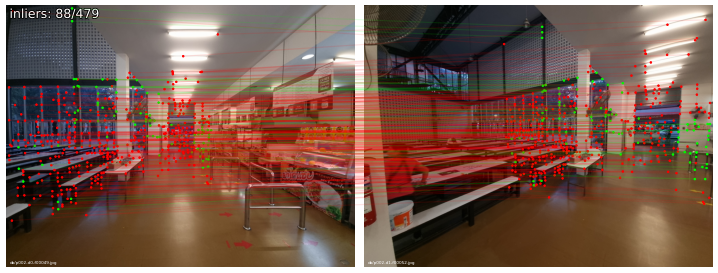

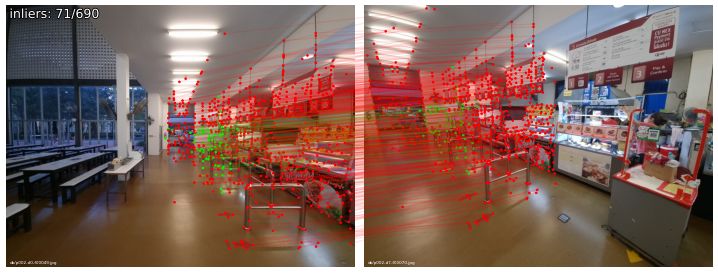

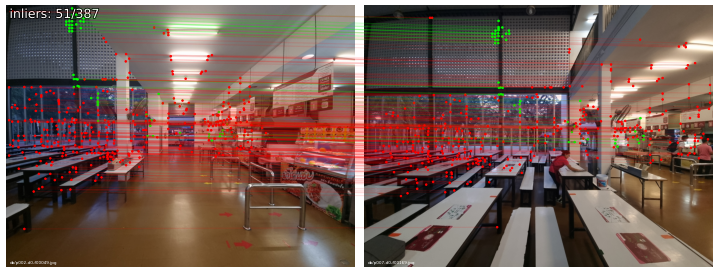

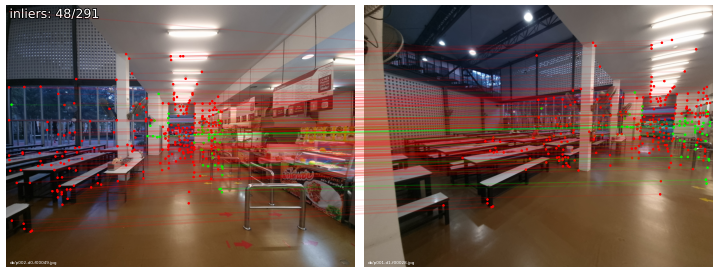

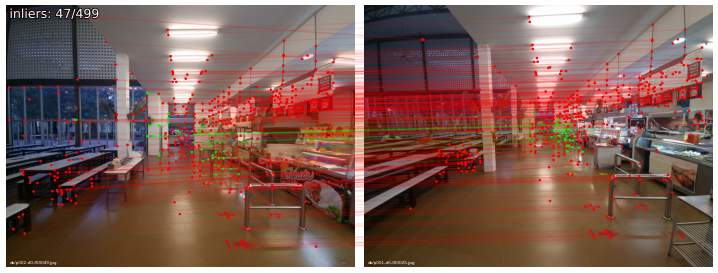

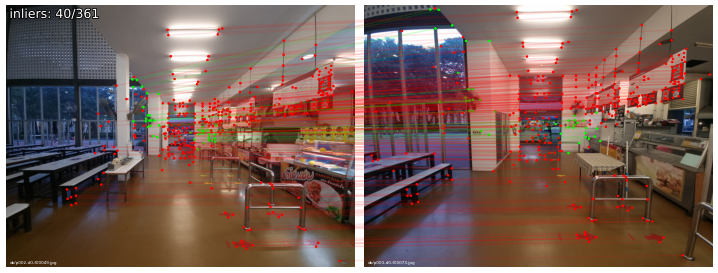

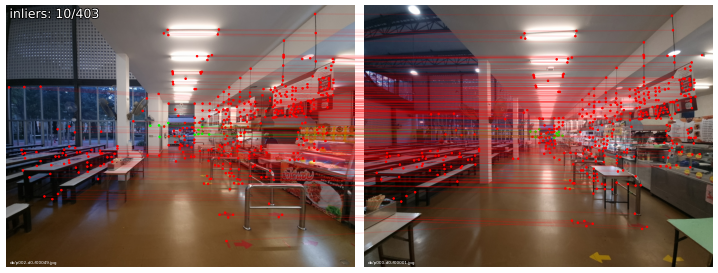

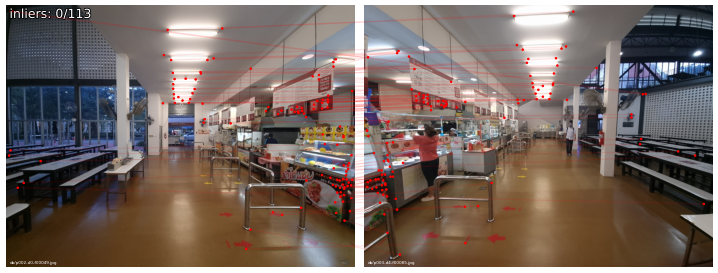

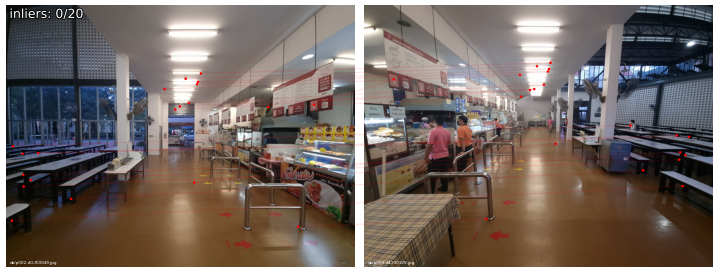

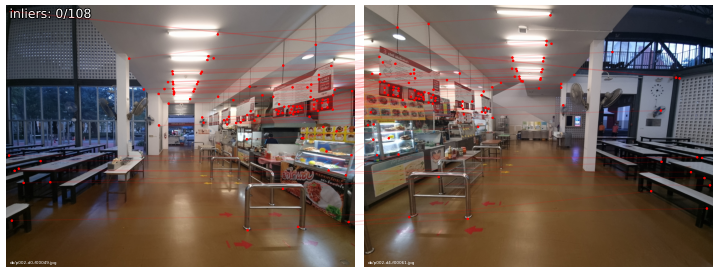

In [195]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(full_im_path)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 5, 
                              'min_num_trials':1000, 
                              'max_num_trials':100000, 
                              # 'min_inlier_ratio':0.1, 
                              # 'confidence':0.1
                             }
                  },
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, im_path, camera, ref_ids, feature_path, match_path)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, im_path, log, model, top_k_db=10, dpi=60)

In [196]:
ret
# log

{'success': True,
 'qvec': array([ 0.19871535, -0.01271181,  0.97976052,  0.02049251]),
 'tvec': array([-2.12976215, -0.00480448,  0.59338854]),
 'num_inliers': 196,
 'inliers': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  Fa

In [85]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=im_path)
fig.show()

NameError: name 'fig' is not defined

In [198]:
im_path

'db/p002-d0-f00049.jpg'

In [ ]:
pose

In [ ]:
image_obj = model.find_image_with_name(im_path)
print(image_obj)
print(image_obj.tvec, image_obj.qvec)


In [ ]:
ret

In [ ]:
ret

In [ ]:
model